# Coursera Capstone Final Project : COVID-19 High Priority Zones

#### Import the necessary libraries

In [1]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
import json # library to handle JSON files
import bs4 as bs
import urllib.request

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

# geocoder
#!conda install -c conda-forge geocoder --yes 
import geocoder

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print('Libraries imported.')

Matplotlib version:  2.2.3
Libraries imported.


#### 1.Building the data frame using BeautifulSoup

In [2]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [3]:
df = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighbourhood"])
df.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,None
1,M2A,Not assigned,None
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Data Cleaning

#### Ignoring rows with 'Not assigned' Boroughs

In [4]:
df = df[df.Borough != 'Not assigned']
df.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [5]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
df.loc[df['Neighbourhood']=='Not assigned', ['Neighbourhood']] = 'Queen\'s Park'
df.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


#### 2. Building the data frame for Neighbourhood Population

In [6]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
skip_table = 1

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find_all('table')[skip_table]
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    #print (tr)
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [7]:
df1 = pd.DataFrame(l, columns=["Neighbourhood", "FM", "Census", "Population", "Land Area", "Density", "Population %", "Income", "Commuting", "Renters", "2nd Language", "2nd Language %"])

# clean up the data and dropping unwanted columns
df1 = df1[df1.Neighbourhood != 'Toronto CMA Average']
df1 = df1.drop('FM', 1)
df1 = df1.drop('Census', 1)
df1 = df1.drop('Renters', 1)
df1 = df1.drop('Income', 1)
df1 = df1.drop('2nd Language', 1)
df1 = df1.drop('2nd Language %', 1)

# change to the proper datatype
df1['Population'] = df1['Population'].str.replace(',','')
df1['Population'] = df1['Population'].apply(pd.to_numeric)
#print (df1.dtypes)

# display sample data
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Commuting
1,Agincourt,44577,12.45,3580,4.6,11.1
2,Alderwood,11656,4.94,2360,-4.0,8.8
3,Alexandra Park,4355,0.32,"13,609",0.0,13.8
4,Allenby,2513,0.58,4333,-1.0,5.2
5,Amesbury,17318,3.51,"4,934",1.1,16.4
6,Armour Heights,4384,2.29,1914,2.0,10.8
7,Banbury,6641,2.72,2442,5.0,6.1
8,Bathurst Manor,14945,4.69,3187,12.3,13.4
9,Bay Street Corridor,4787,0.11,"43,518",3.0,17.1
10,Bayview Village,12280,4.14,"2,966",41.6,14.4


#### Data size

In [8]:
df1.shape

(174, 6)

In [9]:
df.shape

(103, 3)

#### 3. Coordinates of each neighbourhood

In [10]:
df1['Latitude'] = ''
df1['Longitude'] = ''

In [21]:
# loop through the postal code to find out the latitude and longitude
for index, data in df1.iterrows():
    lat_coord = None
    lng_coord = None
    while((lat_coord is None) & (lng_coord is None)):
        geolocator = Nominatim(user_agent = "foursquare_agent")
        address = '{}, Toronto, Ontario'.format(data['Neighbourhood'])
        location = geolocator.geocode(address, timeout = 1000)
        if(location == None):
            break
        else :
            lat_coord = location.latitude
            lng_coord = location.longitude
        data['Latitude'] = lat_coord
        data['Longitude'] = lng_coord
        df1['Latitude'][index] = data['Latitude']
        df1['Longitude'][index] = data['Longitude']
    print ('Neighbourhood:', data['Neighbourhood'], 'Latitude:', data['Latitude'], 'Longitude:', data['Longitude'])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Neighbourhood: Agincourt Latitude: 43.7853531 Longitude: -79.2785494
Neighbourhood: Alderwood Latitude: 43.6017173 Longitude: -79.5452325
Neighbourhood: Alexandra Park Latitude: 43.65075755 Longitude: -79.40430754323067
Neighbourhood: Allenby Latitude: 43.7113509 Longitude: -79.5534236
Neighbourhood: Amesbury Latitude: 43.7061619 Longitude: -79.48349185404643
Neighbourhood: Armour Heights Latitude: 43.7439436 Longitude: -79.4308512
Neighbourhood: Banbury Latitude: 43.7427961 Longitude: -79.3699566407258
Neighbourhood: Bathurst Manor Latitude: 43.76389295 Longitude: -79.45636693710946
Neighbourhood: Bay Street Corridor Latitude: 43.6644565 Longitude: -79.3871893
Neighbourhood: Bayview Village Latitude: 43.7691966 Longitude: -79.3766617
Neighbourhood: Bayview Woods – Steeles Latitude: 43.7981268 Longitude: -79.3829726
Neighbourhood: Bedford Park Latitude: 43.7373876 Longitude: -79.4109253
Neighbourhood: Bendale Latitude: 43.7535196 Longitude: -79.2553355
Neighbourhood: Birch Cliff Latitu

Neighbourhood: Old East York Latitude: 43.699971000000005 Longitude: -79.33251996261595
Neighbourhood: Old Mill/Baby Point Latitude: 43.6558741 Longitude: -79.4964941
Neighbourhood: Parkdale Latitude: 43.6404954 Longitude: -79.4368965
Neighbourhood: Parkway Forest Latitude: 43.77166 Longitude: -79.3426631
Neighbourhood: Parkwoods Latitude: 43.7587999 Longitude: -79.3201966
Neighbourhood: Pelmo Park Latitude: 43.7108008 Longitude: -79.5106305
Neighbourhood: Playter Estates Latitude: 43.6713861 Longitude: -79.3901677
Neighbourhood: Pleasant View Latitude: 43.787048 Longitude: -79.3337137
Neighbourhood: Port Lands Latitude: 43.6430648 Longitude: -79.3506012
Neighbourhood: Port Union Latitude: 43.7755039 Longitude: -79.1349765
Neighbourhood: Princess Gardens Latitude: 43.6404664 Longitude: -79.3912237
Neighbourhood: Regal Heights Latitude: 43.6713861 Longitude: -79.3901677
Neighbourhood: Regent Park/Trefann Court Latitude: 43.6713861 Longitude: -79.3901677
Neighbourhood: Richview Latitude:

#### Updated data frame

In [22]:
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Commuting,Latitude,Longitude
1,Agincourt,44577,12.45,3580,4.6,11.1,43.785353,-79.278549
2,Alderwood,11656,4.94,2360,-4.0,8.8,43.601717,-79.545232
3,Alexandra Park,4355,0.32,"13,609",0.0,13.8,43.650758,-79.404308
4,Allenby,2513,0.58,4333,-1.0,5.2,43.711351,-79.553424
5,Amesbury,17318,3.51,"4,934",1.1,16.4,43.706162,-79.483492
6,Armour Heights,4384,2.29,1914,2.0,10.8,43.743944,-79.430851
7,Banbury,6641,2.72,2442,5.0,6.1,43.742796,-79.369957
8,Bathurst Manor,14945,4.69,3187,12.3,13.4,43.763893,-79.456367
9,Bay Street Corridor,4787,0.11,"43,518",3.0,17.1,43.664457,-79.387189
10,Bayview Village,12280,4.14,"2,966",41.6,14.4,43.769197,-79.376662


In [24]:
# double check on the dataframe
print('The dataframe has {} neighborhoods.'.format(
        len(df1['Neighbourhood'].unique()),
        df1.shape[0]
    )
)

The dataframe has 174 neighborhoods.


#### Adding a population weightage for each Neighbourhood

In [25]:
total_population = df1['Population'].sum()

# the higher populated neighbourhood will have the higher score
df1['Population Score'] = df1['Population']/total_population*100

# sort the dataframe based on the descending population score
df1 = df1.sort_values('Population Score', ascending=False)
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Commuting,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,22.0,43.699971,-79.332520,2.161626
170,Woburn,48507,13.34,3636,-1.5,13.3,43.759824,-79.225291,2.007928
50,Elia (Jane and Finch),48003,7.66,6267,-10.0,13.0,43.757253,-79.517697,1.987065
86,L'Amoreaux,45862,7.15,6414,0.9,13.4,43.799003,-79.305967,1.898439
1,Agincourt,44577,12.45,3580,4.6,11.1,43.785353,-79.278549,1.845247
98,Malvern,44324,8.86,5003,1.5,13.6,43.809196,-79.221701,1.834774
168,Willowdale,43144,7.68,5618,62.3,15.6,43.761510,-79.410923,1.785929
44,Downsview,36613,16.13,2270,-5.0,14.4,43.749299,-79.462248,1.515581
108,Newtonbrook,36046,8.77,4110,0.3,16.6,43.793886,-79.425679,1.492110
139,Smithfield,34996,6.45,5426,-7.2,12.8,43.631184,-79.485667,1.448645


#### Visualising the top 10 Neighbourhoods  using  a bar chart

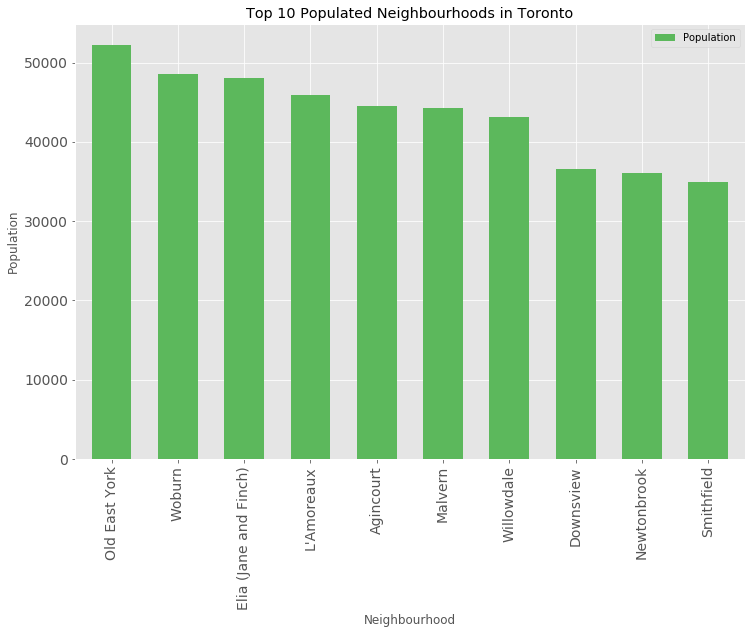

In [26]:
population_chart = df1[['Neighbourhood', 'Population']].copy()
top_chart = population_chart.head(10)
top_chart.set_index('Neighbourhood', inplace=True)

# plot data
colors = ['#5cb85c', '#5bc0de', '#d9534f']
top_chart.plot(kind='bar', figsize=(12, 8), width=0.6, fontsize=14, color=colors)

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Top 10 Populated Neighbourhoods in Toronto') # add title to the plot

plt.show()

### 4. Segmenting and clustering the Toronto Neighbourhood

In [27]:
# Use geopy library to get the latitude and longitude values of Toronto Ontario
address = 'Toronto Ontario, TO'
toronto_data = df1
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Ontario are {}, {}.'.format(latitude, longitude))

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinate of Toronto Ontario are 43.6534817, -79.3839347.


#### create the map of the Toronto Ontario and mark the neighbourhoods

In [28]:
# create map of Toronto Ontario using latitude and longitude values
map_to = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to)  

map_to

### 5. Using Foursquare API to get the venue category and generating a venue score

In [29]:
CLIENT_ID = 'YTRNRWPXBKYQEGLEZPADSE0XSOWZQBC4W3COE3EIZMYQAYET' # your Foursquare ID
CLIENT_SECRET = 'WDNZKYXNWWLLQXUXJPUE3L4QFMXTL2K5P4YYTQYLZ024LQXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: YTRNRWPXBKYQEGLEZPADSE0XSOWZQBC4W3COE3EIZMYQAYET
CLIENT_SECRET:WDNZKYXNWWLLQXUXJPUE3L4QFMXTL2K5P4YYTQYLZ024LQXX


#### Exploring the top neighbourhood

In [34]:
# explore the first neighborhood in our dataframe.
toronto_data.loc[1, 'Neighbourhood']
toronto_data.head(1)

,Neighbourhood,Population,Land Area,Density,Population %,Commuting,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,22.0,43.699971,-79.33252,2.161626


In [35]:
neighborhood_latitude = toronto_data.loc[1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[1, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[1, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Agincourt are 43.7853531, -79.2785494.


#### Explore the top venues from Foursquare API of radius of 500M

In [36]:
# explore the top 100 venues
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=YTRNRWPXBKYQEGLEZPADSE0XSOWZQBC4W3COE3EIZMYQAYET&client_secret=WDNZKYXNWWLLQXUXJPUE3L4QFMXTL2K5P4YYTQYLZ024LQXX&v=20180605&ll=43.7853531,-79.2785494&radius=500&limit=100'

In [37]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ebfdee21a4b0a0028808447'},
 'response': {'headerLocation': 'Agincourt',
  'headerFullLocation': 'Agincourt, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 12,
  'suggestedBounds': {'ne': {'lat': 43.789853104500004,
    'lng': -79.27232780227703},
   'sw': {'lat': 43.7808530955, 'lng': -79.28477099772297}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5058e50ce4b0a3bd556ccbdf',
       'name': 'Tim Hortons',
       'location': {'address': '4200 Sheppard Ave East',
        'crossStreet': 'Midland Ave',
        'lat': 43.78563681034057,
        'lng': -79.27921459078789,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.78563681034057,
          'lng': -79.27921459078789}],
        'distan

In [38]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [39]:
# clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Tim Hortons,Coffee Shop,43.785637,-79.279215
1,One2 Snacks,Asian Restaurant,43.787048,-79.276658
2,In Cheon House Korean & Japanese Restaurant 인천관,Korean Restaurant,43.786468,-79.275693
3,Beef Noodle Restaurant 老李牛肉麵,Chinese Restaurant,43.785937,-79.276031
4,Congee King,Chinese Restaurant,43.785908,-79.276042


In [40]:
# Explore Neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

#### Nearby venues for Toronto Neighbourhoods

In [41]:
# get scarborough venues
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

print(toronto_venues.shape)
toronto_venues.head(10)

Old East York
Woburn
Elia (Jane and Finch)
L'Amoreaux
Agincourt
Malvern
Willowdale
Downsview
Newtonbrook
Smithfield
Fairbank
Riverdale
Don Valley Village
Bendale
Parkdale
Humewood–Cedarvale
Tam O'Shanter – Sullivan
Parkwoods
Milliken
York University Heights
Richview
Scarborough Junction
West Hill
Steeles
Forest Hill
Davisville
Leslieville
High Park North
Rouge
Eglinton East
East Danforth
Don Mills
Flemingdon Park
Mount Dennis
The Beaches
Maple Leaf
Upper Beaches
Eatonville
Glen Park
Hillcrest
Thorncliffe Park
Wexford
Silverthorn
O'Connor–Parkview
Sunnylea
York Mills
Amesbury
Earlscourt
Victoria Village
Thistletown
Pleasant View
Islington – Six Points
Weston
Scarborough City Centre
Westminster
Kingsview Village
Roncesvalles
The Annex
Deer Park
Bathurst Manor
Humbermede
St. James Town
Cliffcrest
Humber Valley Village
Harbourfront / CityPlace
Mimico
Dorset Park
Leaside
Lawrence Manor
Bedford Park
Wilson Heights
Church and Wellesley
Oakridge
Bayview Woods – Steeles
Ionview
Highland Creek
G

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Old East York,43.699971,-79.332520,Taylor Creek Park - West,43.701260,-79.331726,Park
1,Old East York,43.699971,-79.332520,Mon K Patisserie,43.696922,-79.329520,Pastry Shop
2,Old East York,43.699971,-79.332520,LCBO,43.696728,-79.328875,Liquor Store
3,Old East York,43.699971,-79.332520,Remarks Bar & Grill,43.696726,-79.329219,Pub
4,Old East York,43.699971,-79.332520,Pizza Hut,43.696383,-79.328778,Pizza Place
5,Old East York,43.699971,-79.332520,Old East York Village,43.696855,-79.329302,Plaza
6,Woburn,43.759824,-79.225291,GoodLife Fitness Scarborough Cedarbrae Mall,43.759389,-79.226409,Gym
7,Woburn,43.759824,-79.225291,Shoppers Drug Mart,43.759825,-79.225268,Pharmacy
8,Woburn,43.759824,-79.225291,Staples Cedarbrae,43.759851,-79.228335,Paper / Office Supplies Store
9,Woburn,43.759824,-79.225291,Pizza Pizza,43.759321,-79.224929,Pizza Place


In [42]:
# find out how many unique categories
toronto_venues.groupby('Neighbourhood').count()
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 313 uniques categories.


#### Analysing each Neighbourhood in Toronto

In [43]:
# analyze each neighborhood

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Suppleme

In [44]:
toronto_onehot.shape

(4623, 314)

#### Group the rows together based on the mean of the frequency of occurrence of each category

In [45]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head(10)

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Suppleme

In [46]:
toronto_grouped.shape

(171, 314)

#### Finding the top 10 common venues in the neighbourhood

In [48]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    

# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

toronto_grouped.shape[0]
toronto_grouped.head()

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Suppleme

#### Exploring top 8 venues of each neighbourhood

In [49]:
# create the new dataframe and display the top 8 venues for each neighborhood.
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Chinese Restaurant,Cantonese Restaurant,Coffee Shop,Food Court,Korean Restaurant,Hong Kong Restaurant,Vietnamese Restaurant,Shopping Mall
1,Alderwood,Pizza Place,Sandwich Place,Pool,Pub,Skating Rink,Pharmacy,Gym,Coffee Shop
2,Alexandra Park,Bar,Furniture / Home Store,Coffee Shop,Café,Caribbean Restaurant,Arts & Crafts Store,Arepa Restaurant,Boutique
3,Allenby,Restaurant,Bookstore,Frame Store,African Restaurant,Intersection,Café,Fast Food Restaurant,Fish & Chips Shop
4,Amesbury,Park,Intersection,Gas Station,Athletics & Sports,Bank,Coffee Shop,Yoga Studio,Filipino Restaurant
5,Armour Heights,Pharmacy,Market,Deli / Bodega,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
6,Banbury,Park,Auto Garage,Tennis Court,Yoga Studio,Filipino Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant
7,Bathurst Manor,Convenience Store,Playground,Baseball Field,Park,Yoga Studio,Fish & Chips Shop,Event Space,Falafel Restaurant
8,Bay Street Corridor,Sushi Restaurant,Yoga Studio,Café,Coffee Shop,Martial Arts Dojo,Mexican Restaurant,Bubble Tea Shop,Food & Drink Shop
9,Bayview Village,Bank,Fish Market,Sandwich Place,Outdoor Supply Store,Clothing Store,Gas Station,Fast Food Restaurant,Persian Restaurant


#### Venue weighted score for each neighbourhood

In [50]:
neighborhoods_venues_sorted['Venue Score'] = 0
venue = 'Park'
venue_count = 0

# award the score based on the common findings
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains(venue), ['Venue Score']] = 1.0
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.9
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.8
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['4th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.7
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['5th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.6
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['6th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.5
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['7th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.4
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['8th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.3

# merge the two dataframes
merged_data = pd.merge(df1, neighborhoods_venues_sorted, on='Neighbourhood')

# clean up the merged dataset
merged_data = merged_data.drop('1st Most Common Venue', 1)
merged_data = merged_data.drop('2nd Most Common Venue', 1)
merged_data = merged_data.drop('3rd Most Common Venue', 1)
merged_data = merged_data.drop('4th Most Common Venue', 1)
merged_data = merged_data.drop('5th Most Common Venue', 1)
merged_data = merged_data.drop('6th Most Common Venue', 1)
merged_data = merged_data.drop('7th Most Common Venue', 1)
merged_data = merged_data.drop('8th Most Common Venue', 1)
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)

merged_data.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Commuting,Latitude,Longitude,Population Score,Venue Score
0,Old East York,52220,7.94,6577,-4.6,22.0,43.699971,-79.332520,2.161626,0.7
1,Woburn,48507,13.34,3636,-1.5,13.3,43.759824,-79.225291,2.007928,0.0
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,13.0,43.757253,-79.517697,1.987065,0.0
3,L'Amoreaux,45862,7.15,6414,0.9,13.4,43.799003,-79.305967,1.898439,0.0
4,Agincourt,44577,12.45,3580,4.6,11.1,43.785353,-79.278549,1.845247,0.0
5,Malvern,44324,8.86,5003,1.5,13.6,43.809196,-79.221701,1.834774,0.7
6,Willowdale,43144,7.68,5618,62.3,15.6,43.761510,-79.410923,1.785929,0.0
7,Downsview,36613,16.13,2270,-5.0,14.4,43.749299,-79.462248,1.515581,0.0
8,Newtonbrook,36046,8.77,4110,0.3,16.6,43.793886,-79.425679,1.492110,0.0
9,Smithfield,34996,6.45,5426,-7.2,12.8,43.631184,-79.485667,1.448645,0.0


#### Lets calculate a final score based on the population score and the venue score

In [51]:
# considering this to be a fair weightage on both parameters
population_weight = 0.5
venue_weight = 0.5

# calculate the total score
merged_data['Total Score'] = (merged_data['Population Score']*population_weight) + (merged_data['Venue Score']*venue_weight)

# sort the dataframe based on the descending total score
merged_data = merged_data.sort_values('Total Score', ascending=False)

### 6. K-means clustering

In [54]:
# set number of clusters
kclusters = 5

#toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# clean up data further
toronto_grouped_clustering = merged_data.drop('Neighbourhood', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Density', 1)

toronto_grouped_clustering.head(10)

,Population,Land Area,Population %,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score
0,52220,7.94,-4.6,22.0,43.699971,-79.332520,2.161626,0.7,1.430813
5,44324,8.86,1.5,13.6,43.809196,-79.221701,1.834774,0.7,1.267387
1,48507,13.34,-1.5,13.3,43.759824,-79.225291,2.007928,0.0,1.003964
2,48003,7.66,-10.0,13.0,43.757253,-79.517697,1.987065,0.0,0.993533
27,22746,2.18,-1.6,27.5,43.657383,-79.470961,0.941562,1.0,0.970781
10,34121,4.42,-3.6,21.6,43.695689,-79.450310,1.412425,0.5,0.956213
3,45862,7.15,0.9,13.4,43.799003,-79.305967,1.898439,0.0,0.949220
4,44577,12.45,4.6,11.1,43.785353,-79.278549,1.845247,0.0,0.922624
28,22724,28.72,175.0,12.1,43.804930,-79.165837,0.940651,0.9,0.920325
24,24056,4.35,-0.2,14.8,43.693559,-79.413902,0.995789,0.8,0.897894


In [55]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 1, 4, 2, 2, 1, 4])

In [56]:
# empty the invalid data
#merged_data['Neighbourhood'] = neighborhoods_venues_sorted['Neighbourhood']
#print(toronto_data.shape)
merged_data.isnull().sum()
merged_data.dropna(how = 'any', axis = 0, inplace = True)
print(merged_data.shape)
print(neighborhoods_venues_sorted.shape)

(171, 11)
(171, 9)


In [57]:
merged_data.head()

,Neighbourhood,Population,Land Area,Density,Population %,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score
0,Old East York,52220,7.94,6577,-4.6,22.0,43.699971,-79.332520,2.161626,0.7,1.430813
5,Malvern,44324,8.86,5003,1.5,13.6,43.809196,-79.221701,1.834774,0.7,1.267387
1,Woburn,48507,13.34,3636,-1.5,13.3,43.759824,-79.225291,2.007928,0.0,1.003964
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,13.0,43.757253,-79.517697,1.987065,0.0,0.993533
27,High Park North,22746,2.18,"10,434",-1.6,27.5,43.657383,-79.470961,0.941562,1.0,0.970781


In [58]:
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Chinese Restaurant,Cantonese Restaurant,Coffee Shop,Food Court,Korean Restaurant,Hong Kong Restaurant,Vietnamese Restaurant,Shopping Mall
1,Alderwood,Pizza Place,Sandwich Place,Pool,Pub,Skating Rink,Pharmacy,Gym,Coffee Shop
2,Alexandra Park,Bar,Furniture / Home Store,Coffee Shop,Café,Caribbean Restaurant,Arts & Crafts Store,Arepa Restaurant,Boutique
3,Allenby,Restaurant,Bookstore,Frame Store,African Restaurant,Intersection,Café,Fast Food Restaurant,Fish & Chips Shop
4,Amesbury,Park,Intersection,Gas Station,Athletics & Sports,Bank,Coffee Shop,Yoga Studio,Filipino Restaurant


In [59]:
toronto_merged = toronto_data

# add clustering labels
merged_data['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = merged_data.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Neighbourhood,Population,Land Area,Density,Population %,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Old East York,52220,7.94,6577,-4.6,22.0,43.699971,-79.332520,2.161626,0.7,1.430813,2,Plaza,Pub,Pizza Place,Park,Pastry Shop,Liquor Store,Yoga Studio,Farmers Market
5,Malvern,44324,8.86,5003,1.5,13.6,43.809196,-79.221701,1.834774,0.7,1.267387,2,Pizza Place,Pharmacy,Fast Food Restaurant,Park,Grocery Store,Bubble Tea Shop,Sandwich Place,Skating Rink
1,Woburn,48507,13.34,3636,-1.5,13.3,43.759824,-79.225291,2.007928,0.0,1.003964,2,Fast Food Restaurant,Bank,Discount Store,Coffee Shop,Pizza Place,Hardware Store,Sandwich Place,Beer Store
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,13.0,43.757253,-79.517697,1.987065,0.0,0.993533,2,Discount Store,Pizza Place,Shopping Mall,Grocery Store,Fast Food Restaurant,Sandwich Place,Caribbean Restaurant,Liquor Store
27,High Park North,22746,2.18,"10,434",-1.6,27.5,43.657383,-79.470961,0.941562,1.0,0.970781,1,Park,Gym / Fitness Center,Baseball Field,Tennis Court,Yoga Studio,Filipino Restaurant,Event Space,Falafel Restaurant


#### Cluster Map

In [60]:
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 7. Final Evaluation

In [62]:
# display the top 5 neighbourhoods
target = merged_data.head(5)
target.head()
#toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].count()

,Neighbourhood,Population,Land Area,Density,Population %,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels
0,Old East York,52220,7.94,6577,-4.6,22.0,43.699971,-79.332520,2.161626,0.7,1.430813,2
5,Malvern,44324,8.86,5003,1.5,13.6,43.809196,-79.221701,1.834774,0.7,1.267387,2
1,Woburn,48507,13.34,3636,-1.5,13.3,43.759824,-79.225291,2.007928,0.0,1.003964,2
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,13.0,43.757253,-79.517697,1.987065,0.0,0.993533,2
27,High Park North,22746,2.18,"10,434",-1.6,27.5,43.657383,-79.470961,0.941562,1.0,0.970781,1


In [68]:
# Cluster 1 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Total Score', ascending=False).head(5)

,Neighbourhood,Population,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
125,Banbury,6641,6.1,43.742796,-79.369957,0.274902,1.0,0.637451,0,Park,Auto Garage,Tennis Court,Yoga Studio,Filipino Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant
126,Carleton Village,6544,19.0,43.670701,-79.453299,0.270886,1.0,0.635443,0,Park,Dog Run,Coffee Shop,Jewelry Store,Yoga Studio,Eastern European Restaurant,Ethiopian Restaurant,Event Space
127,Niagara,6524,21.2,43.641406,-79.404362,0.270058,1.0,0.635029,0,Park,Bakery,Restaurant,Gym / Fitness Center,Spa,Brewery,Italian Restaurant,Asian Restaurant
134,Westmount,5857,9.6,43.693640,-79.521043,0.242448,1.0,0.621224,0,Park,Pizza Place,Gas Station,Yoga Studio,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Falafel Restaurant
117,Eringate,8008,10.9,43.662273,-79.576516,0.331488,0.9,0.615744,0,Playground,Park,Yoga Studio,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market


In [69]:
# Cluster 2 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Total Score', ascending=False).head(5)

,Neighbourhood,Population,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
27,High Park North,22746,27.5,43.657383,-79.470961,0.941562,1.0,0.970781,1,Park,Gym / Fitness Center,Baseball Field,Tennis Court,Yoga Studio,Filipino Restaurant,Event Space,Falafel Restaurant
28,Rouge,22724,12.1,43.804930,-79.165837,0.940651,0.9,0.920325,1,Convenience Store,Park,Fast Food Restaurant,Yoga Studio,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Falafel Restaurant
34,The Beaches,20416,13.8,43.671024,-79.296712,0.845112,0.9,0.872556,1,Beach,Park,Japanese Restaurant,Bar,Tea Room,Pharmacy,Breakfast Spot,Pizza Place
46,Amesbury,17318,16.4,43.706162,-79.483492,0.716872,1.0,0.858436,1,Park,Intersection,Gas Station,Athletics & Sports,Bank,Coffee Shop,Yoga Studio,Filipino Restaurant
36,Upper Beaches,19830,18.6,43.678488,-79.310819,0.820855,0.8,0.810427,1,Hungarian Restaurant,Café,Park,Asian Restaurant,Flower Shop,Fish & Chips Shop,Event Space,Falafel Restaurant


In [70]:
# Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Total Score', ascending=False).head(5)

,Neighbourhood,Population,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Old East York,52220,22.0,43.699971,-79.332520,2.161626,0.7,1.430813,2,Plaza,Pub,Pizza Place,Park,Pastry Shop,Liquor Store,Yoga Studio,Farmers Market
5,Malvern,44324,13.6,43.809196,-79.221701,1.834774,0.7,1.267387,2,Pizza Place,Pharmacy,Fast Food Restaurant,Park,Grocery Store,Bubble Tea Shop,Sandwich Place,Skating Rink
1,Woburn,48507,13.3,43.759824,-79.225291,2.007928,0.0,1.003964,2,Fast Food Restaurant,Bank,Discount Store,Coffee Shop,Pizza Place,Hardware Store,Sandwich Place,Beer Store
2,Elia (Jane and Finch),48003,13.0,43.757253,-79.517697,1.987065,0.0,0.993533,2,Discount Store,Pizza Place,Shopping Mall,Grocery Store,Fast Food Restaurant,Sandwich Place,Caribbean Restaurant,Liquor Store
3,L'Amoreaux,45862,13.4,43.799003,-79.305967,1.898439,0.0,0.949220,2,Chinese Restaurant,Bus Stop,Shopping Mall,Athletics & Sports,Coffee Shop,Event Space,Falafel Restaurant,Farmers Market


In [71]:
# Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Total Score', ascending=False).head(5)

,Neighbourhood,Population,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
79,Centennial,12565,11.5,43.787491,-79.150768,0.520123,1.0,0.760062,3,Park,Yoga Studio,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
80,Port Union,12450,11.1,43.775504,-79.134976,0.515363,1.0,0.757681,3,Park,Yoga Studio,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
81,Ledbury Park,12360,9.5,43.726661,-79.423638,0.511637,1.0,0.755819,3,Park,Bagel Shop,Coffee Shop,Wings Joint,Bridal Shop,Bakery,Baby Store,Bus Line
83,Birch Cliff,12266,11.4,43.702112,-79.260091,0.507746,1.0,0.753873,3,Park,Gym,Gym Pool,Baseball Field,Filipino Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant
68,Lawrence Manor,13750,15.9,43.722079,-79.437507,0.569176,0.9,0.734588,3,Bank,Park,Kids Store,Doctor's Office,Electronics Store,Filipino Restaurant,Ethiopian Restaurant,Event Space


In [72]:
# Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Total Score', ascending=False).head(5)

,Neighbourhood,Population,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
10,Fairbank,34121,21.6,43.695689,-79.450310,1.412425,0.5,0.956213,4,Mexican Restaurant,Pharmacy,Bank,Bakery,Grocery Store,Park,Coffee Shop,Discount Store
24,Forest Hill,24056,14.8,43.693559,-79.413902,0.995789,0.8,0.897894,4,Bank,Playground,Park,Yoga Studio,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Falafel Restaurant
7,Downsview,36613,14.4,43.749299,-79.462248,1.515581,0.0,0.757790,4,Bus Station,Coffee Shop,Metro Station,French Restaurant,Gym / Fitness Center,Gym Pool,Gas Station,Falafel Restaurant
8,Newtonbrook,36046,16.6,43.793886,-79.425679,1.492110,0.0,0.746055,4,Café,Korean Restaurant,Coffee Shop,Middle Eastern Restaurant,Fast Food Restaurant,Restaurant,Discount Store,Auto Dealership
9,Smithfield,34996,12.8,43.631184,-79.485667,1.448645,0.0,0.724323,4,Coffee Shop,Bank,Italian Restaurant,Sandwich Place,Liquor Store,Grocery Store,Farmers Market,Smoothie Shop


### 8. Final analysis

Based on the result above results, the top high priority zones are identified with respect to the total score generated. According to the total score, the top 5 high priority zones are: Old East York, Malvern, Woburn, Elia(Jane & Finch) and High Park North. These are the neighbourhoods that need high attention. The third cluster has the highest scores, hence it has to be prioritised.

The top neighbourhoods of each cluster could also be considered as virus hotspots, since they are the ones with high population and also more busy venues. The top neighbourhoods must be strictly under lockdown and the testing of the virus must happen in a large scale in these areas. The zones can be assigned as per the clusters formed:
Red zone: Cluster 2,3 and 5
Orange zone: Cluster 1 and 4

The Toronto police department can further put its requirements to the data science team to improve the security and safety of its citizens. The project can be further developed when a feature regarding the existing number of active cases in a neighbourhood is available. That will give a better picture on the scenario.